In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

from overlapped_classes import overlapped_classes
import json
from PIL import Image
import scipy

In [2]:
with open("../mappings/pytorch_to_imagenet_2012_id.json") as f:
    idxMap = json.load(f)

with open('imagenet_classes.txt') as f:
# with open('../mappings/imagenet_to_label_2012_v2.txt') as f:    
    labels = [line.strip() for line in f.readlines()]    

In [3]:
# !pip install torchattacks

In [4]:
from torchattacks import FGSM, PGD

In [5]:
# labels

In [6]:
# overlapped_classes
# data['Alarm clock']
# idxMap

In [7]:
# for i in overlapped_classes:
#     print(data[i] in labels)
#     print(f"{i} : {data[i]}")
# del model

In [8]:
from torchvision import models
dir(models)



# model = models.alexnet(pretrained=True)
model = models.resnet152(pretrained=True)
# model = models.inception_v3(pretrained=True)
# model = models.googlenet(pretrained=True)

model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
def predict_image(image_path, draw=False):
    # Define transformations for the image, should (note that imagenet models are trained with image size 224)
    transform = transforms.Compose([
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))    

    ])
    
#     import pdb; pdb.set_trace()
    if isinstance(image_path, str):
        img = Image.open(image_path).convert("RGB")
    else:
        img = image_path 
    
#     xl, yl, xr, yr = box
#     img = img.crop((xl, yl, xr, yr))   #((left, top, right, bottom)) 
    img = img.resize((224, 224))

    img_t = transform(img).float()

#     img_t = img_t.permute((0,1,2))
#     img_t = torch.transpose(img_t, 0, 1)  # rotate
    
    if draw:
        plt.imshow(img) #img_t.permute((2,1,0)) )
    # ##    plt.imshow(torch.transpose(img_t.permute((1,2,0)),  0, 1))
        plt.show()

#     print(img_t.shape)
    # Preprocess the image
#     image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
#     image_tensor = image_tensor.unsqueeze_(0)
    image_tensor = img_t.unsqueeze_(0)

    if torch.cuda.is_available():
        image_tensor.cuda()

    # Turn the input into a Variable
#     input = Variable(image_tensor)

    # Predict the class of the image
    output = model(image_tensor)

#     index = output.data.numpy().argmax()  # top 1
    _, indices = torch.sort(output.data, descending=True)
#     [(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]
    return indices[0][:5] # index

In [10]:
# len(data)
# dirMap[category]


In [11]:
pred = predict_image('./imgs/1.jpg')


# perform this for different levels of sigma
# invariance to edges

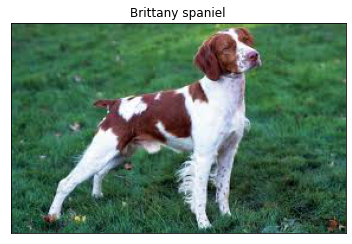

In [185]:
# Import Pillow


# img_t = img_t.permute((2,1,0))

# img_t = torch.transpose(img_t, 0, 1)

# np.clip
# img_t = torch.unsqueeze(img_t, 0)
# help(img_t.transpose)


pred = predict_image('./imgs/1.jpg')
plt.title(labels[pred[0].item()])
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

# img = cv2.imread("../images/air_freshener/01d44a4b77b44a0.png", cv2.IMREAD_UNCHANGED)
# img = cv2cvLoadImage("../images/air_freshener/01d44a4b77b44a0.png", CV_LOAD_IMAGE_UNCHANGED)


## edge detection

In [10]:
# pip install scikit-image


In [12]:
from skimage import io, color, feature

def detect_edge(data):
    edge_maps = np.zeros_like(data)
    for idx,img in enumerate(data):
#         import pdb; pdb.set_trace()
        edge_maps[idx,0] = feature.canny(np.array(img[0], dtype=np.float64))#, sigma = 1, low_threshold=1.5) #, high_threshold=.1)

    return edge_maps

In [13]:

import cv2
def auto_canny(image, sigma=100):
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    return edged

In [15]:
# Converting the image to grayscale.
import cv2

# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def detect_edge_new(img):
  fgbg = cv2.createBackgroundSubtractorMOG2(
        history=10,
        varThreshold=2,
        detectShadows=False)

  gray = np.array(img.mean(axis=2)*255).astype('uint8')

  # Extract the foreground
  edges_foreground = cv2.bilateralFilter(gray, 9, 75, 75)
  foreground = fgbg.apply(edges_foreground)

  # Smooth out to get the moving area
  kernel = np.ones((50,50),np.uint8)
  foreground = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)

  # Applying static edge extraction
  edges_foreground = cv2.bilateralFilter(gray, 9, 75, 75)
  edges_filtered = cv2.Canny(edges_foreground, 30, 100)

  # Crop off the edges out of the moving area
  cropped = (foreground // 255) * edges_filtered

  return cropped#edges_filtered

In [16]:
img_2 = np.array(img).astype('uint8')/255.
edge_map = detect_edge_new(img_2)
# auto_canny(img_2)

plt.title(f"img")
plt.imshow(edge_map)
plt.xticks([])
plt.yticks([])
plt.show()

NameError: name 'img' is not defined

## Perform the attack now and repeat

In [ ]:
transform = transforms.Compose([
#         transforms.CenterCrop(224),
    transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))    

])



from PIL import Image



fgsm_attack = FGSM(model, eps=32/256)

img_names = ['1', '5']


f,ax=plt.subplots(2,6,figsize=(14,7))
ax=ax.flatten()

for i, img_name in enumerate(img_names):

    img = Image.open(f'./imgs/{img_name}.jpg').convert('RGB')


    pred = predict_image(f'./imgs/{img_name}.jpg')
    # plt.title(labels[pred[0].item()])
    # plt.imshow(img)
    # plt.xticks([])
    # plt.yticks([])
    # plt.show()

    ax[i].imshow(img)
    ax[i].set_title(pred[0].item())
    ax[i].set_xticks([])
    ax[i].set_yticks([])    
    
    i +=1





    img_adv = fgsm_attack(transform(img).unsqueeze(0),torch.tensor([pred[0].item()]))
    # img_adv = img_adv - torch.tensor((0.485, 0.456, 0.406))

    output = model(img_adv)
    #     index = output.data.numpy().argmax()  # top 1
    _, indices = torch.sort(output.data, descending=True)


    pred = indices[0][:5]

    # plt.title(labels[pred[0].item()])
    # plt.imshow(img_adv[0].permute(1,2,0))
    # plt.xticks([])
    # plt.yticks([])
    # plt.show()


    ax[i].imshow(img_adv[0].permute(1,2,0))
    ax[i].set_title(pred[0].item())
    ax[i].set_xticks([])
    ax[i].set_yticks([])    
    
    i +=1









#     # plt.title('diference')
#     # plt.imshow(img_adv[0].permute(1,2,0)*255 - np.array(img))
#     # plt.xticks([])
#     # plt.yticks([])
#     # plt.show()


# #     plt.title('diference')
#     # diff = torch.norm(img_adv[0].permute(1,2,0)*255 - np.array(img), float('inf'))
#     # diff = torch.abs(img_adv[0].permute(1,2,0)*255 - np.array(img))
#     diff = torch.abs(img_adv[0].permute(1,2,0)*255 - np.array(img))
#     diff = (diff - diff.min()) / (diff.max() - diff.min())
#     # diff = img_adv[0].permute(1,2,0)*255 - np.array(img)
#     # plt.imshow(diff)
#     # plt.xticks([])
#     # plt.yticks([])
#     # plt.show()


#     ax[i].imshow(diff)
#     ax[i].set_title('diff')
#     ax[i].set_xticks([])
#     ax[i].set_yticks([])    
    
#     i +=1














#     # img = np.array(img*255)
#     # img_2 = np.array(img).astype('uint8')
#     # edge_map = auto_canny(img_2)
#     img_2 = np.array(img).astype('uint8')/255.
#     edge_map = detect_edge_new(img_2)

#     # plt.title(f"img")
#     # plt.imshow(edge_map)
#     # plt.xticks([])
#     # plt.yticks([])
#     # plt.show()


#     ax[i].imshow(edge_map)
#     ax[i].set_title('edge map')
#     ax[i].set_xticks([])
#     ax[i].set_yticks([])    
    
#     i +=1
















#     # img_avd_2 = np.array(img_adv*255.).astype('uint8')
#     # edge_map_adv = auto_canny(img_avd_2[0].transpose(1,2,0))
#     img_avd_2 = np.array(img_adv*255.).astype('uint8')/255.
#     edge_map_adv = detect_edge_new(img_avd_2[0].transpose(1,2,0))


#     # plt.title(f"fgsm eps={8/256}")
#     # plt.imshow(edge_map_adv)
#     # plt.xticks([])
#     # plt.yticks([])
#     # plt.show()


#     ax[i].imshow(edge_map_adv)
#     ax[i].set_title('edge map adversarial')
#     ax[i].set_xticks([])
#     ax[i].set_yticks([])    
#     i +=1











# #     plt.title(f"edge map diff")
# #     plt.imshow(edge_map-edge_map_adv)
# #     plt.xticks([])
# #     plt.yticks([])
# #     plt.show()



#     ax[i].imshow(edge_map-edge_map_adv)
#     ax[i].set_title('edge map adversarial')
#     ax[i].set_xticks([])
#     ax[i].set_yticks([])    
    
#     i +=1



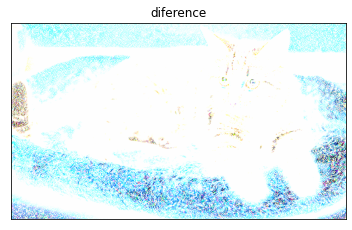

In [511]:
plt.title('diference')
# diff = torch.norm(img_adv[0].permute(1,2,0)*255 - np.array(img), float('inf'))
# diff = torch.abs(img_adv[0].permute(1,2,0)*255 - np.array(img))
diff = torch.abs(img_adv[0].permute(1,2,0)*255 - np.array(img)/1.)
diff = (diff - diff.min()) / (diff.max() - diff.min())
# diff = img_adv[0].permute(1,2,0)*255 - np.array(img)
plt.imshow(diff)
plt.xticks([])
plt.yticks([])
plt.show()

In [501]:
# torch.abs(diff.max())
diff.max()
edge_map.max()
# (img_adv[0].permute(1,2,0)*255).max()
# np.array(img).max()
# np.array(img).min()
# (img_adv[0].permute(1,2,0)*255).min()
# diff.shape

255

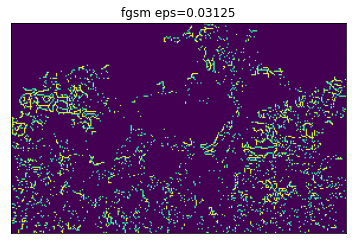

In [354]:
plt.title(f"fgsm eps={8/256}")
plt.imshow(edge_map-edge_map_adv)
plt.xticks([])
plt.yticks([])
plt.show()


In [336]:
np.array(img).max()
img_avd_2.shape

(1, 3, 178, 283)

In [264]:
img = Image.open("./imgs/1.jpg").convert('RGB')
np.array(img_adv).astype('uint8').dtype

dtype('uint8')

In [266]:
img_avd_2.dtype

dtype('uint8')

In [370]:
inp = cv2.dnn.blobFromImage(np.array(img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


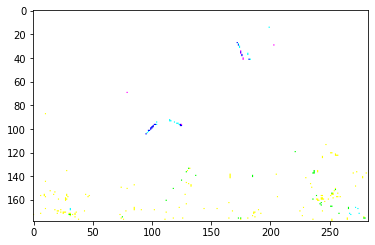

In [374]:
plt.imshow(inp[0].transpose(1,2,0))

In [376]:
net.setInput(inp)
out = net.forward()
out = out[0, 0]
out = cv.resize(out, (frame.shape[1], frame.shape[0]))
out = 255 * out
out = out.astype(np.uint8)
out=cv.cvtColor(out,cv.COLOR_GRAY2BGR)
con=np.concatenate((frame,out),axis=1)
cv.imshow(kWinName,con)

NameError: name 'net' is not defined

In [378]:
!sh download_pretrained.sh

sh: download_pretrained.sh: No such file or directory
